## Analysis

In this section we implement the analysis we took to arrive at the answers to our established research questions. We include the code used for clarity. To answer the first research question we load in necessary librairies and clean the data pulled from the database using SQL queries. Specifically we exclude irrelevant columns, and adjust data types.

In [1]:
import pandas as pd
import altair as alt
import numpy as np
import openpyxl
import math
import matplotlib.pyplot as plt

In [2]:
# Load and clean data
expenditure_by_party_df = pd.read_csv('../Data/Clean/from_sql/expenditure_by_party.csv')
expenditure_by_party_df = expenditure_by_party_df.iloc[2:-1]
expenditure_by_party_df.columns = ['province', 'year', 'party', 'percent_expenditure_change']
expenditure_by_party_df

expenditure_by_party_df['percent_expenditure_change'] = pd.to_numeric(
    expenditure_by_party_df['percent_expenditure_change'], errors='coerce'
)
expenditure_by_party_df['year'] = pd.to_numeric(
    expenditure_by_party_df['year'], errors='coerce'
)
expenditure_by_party_df['party'] = expenditure_by_party_df['party'].astype(str)
expenditure_by_party_df['province'] = expenditure_by_party_df['province'].astype(str)


expenditure_by_party_df

,province,year,party,percent_expenditure_change
2,Alberta,2000,Conservative Party,10.2
3,BritishColumbia,2000,NDP,9.2
4,Ontario,2000,Conservative Party,10.9
5,Alberta,2001,Conservative Party,13.2
6,BritishColumbia,2001,NDP,10.4
...,...,...,...,...
72,BritishColumbia,2023,NDP,8.9
73,Ontario,2023,Conservative Party,2.1
74,Alberta,2024,Conservative Party,5.0
75,BritishColumbia,2024,NDP,12.0


Next we look at the mean and standard deviation of percent expenditure change by party.

In [3]:
# Group by the 'party' column and calculate mean and standard deviation
summary_stats = expenditure_by_party_df.groupby('party')['percent_expenditure_change'].agg(['mean', 'std']).reset_index()

print(summary_stats)

                party      mean       std
0  Conservative Party  7.200000  3.594799
1       Liberal Party  4.710000  1.851812
2                 NDP  7.253846  3.394018


We notice that the Conservative Party and NDP have significantly higher mean percent increase in health expenditure year over year. 

We now establish the first ANOVA hypothesis test:

Our null hypothesis is that the mean health expenditure percent increase is equal amongst all three parties.

Our alternative hypothesis is that at least one party has a different mean percent expenditure change than the others. 

We set our significance level at 0.05 for this test.

Now we conduct an ANOVA test to verify our results.

In [4]:
from scipy.stats import f_oneway

# Separate the data by party
conservative_data = expenditure_by_party_df.loc[expenditure_by_party_df['party'] == 'Conservative Party', 'percent_expenditure_change']
ndp_data = expenditure_by_party_df.loc[expenditure_by_party_df['party'] == 'NDP', 'percent_expenditure_change']
liberal_data = expenditure_by_party_df.loc[expenditure_by_party_df['party'] == 'Liberal Party', 'percent_expenditure_change']

# Perform one-way ANOVA
f_stat, p_value = f_oneway(conservative_data, ndp_data, liberal_data)
print("F-statistic:", f_stat)
print("p-value:", p_value)

F-statistic: 6.374928458496168
p-value: 0.0028246641620859837


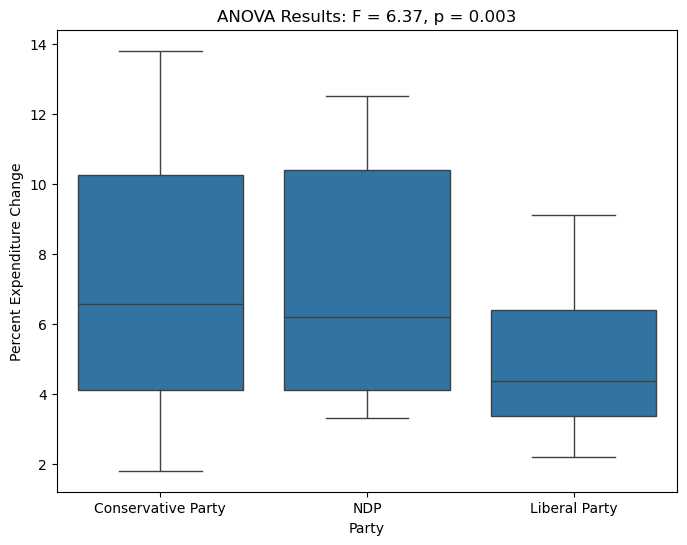

In [5]:
import seaborn as sns

# Create a boxplot to visualize percent expenditure change by party
plt.figure(figsize=(8, 6))
sns.boxplot(x='party', y='percent_expenditure_change', data=expenditure_by_party_df)

# Add a title with the ANOVA results
plt.title(f'ANOVA Results: F = {f_stat:.2f}, p = {p_value:.3f}')
plt.xlabel('Party')
plt.ylabel('Percent Expenditure Change')

# Save the figure to a file
plt.savefig('../Figures/anova_boxplot.png', dpi=300)
plt.show()

From this test we reject our null hypothesis and state that there is a significant difference in percent health expendenture change between the parties. 

We now conduct pairwise hypothesis tests to verify which party is indeed different. 

Firstly, we compare Liberal and Conservative parties. 

The null hypothesis is that the mean health expenditure change is the same  between them, the alternative hypothesis is that the Conservative parties mean is higher, and we set a significance level of 0.05.

In [6]:
from scipy.stats import ttest_ind

# Perform two-tailed t-test:
t_stat, p_value_two_tailed = ttest_ind(conservative_data, liberal_data, equal_var=True)

# Convert to one-tailed p-value:
if t_stat > 0:
    p_value_one_tailed = p_value_two_tailed / 2
else:
    p_value_one_tailed = 1 - (p_value_two_tailed / 2)

print("t-statistic:", t_stat)
print("One-tailed p-value:", p_value_one_tailed)

t-statistic: 3.3939804081297527
One-tailed p-value: 0.0006129004817036798


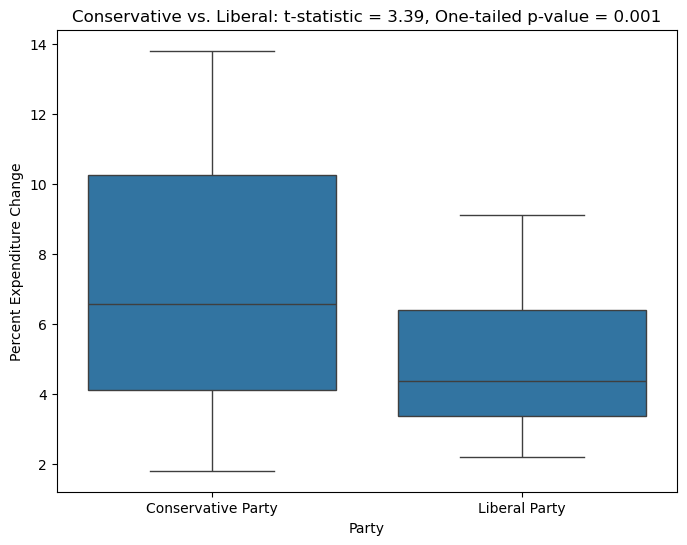

In [7]:
# Filter the dataframe to include only Conservative and Liberal parties
subset_df = expenditure_by_party_df[expenditure_by_party_df['party'].isin(['Conservative Party', 'Liberal Party'])]

# Create a boxplot to compare the two parties
plt.figure(figsize=(8, 6))
sns.boxplot(x='party', y='percent_expenditure_change', data=subset_df)

# Annotate the plot with the t-test results
plt.title(f"Conservative vs. Liberal: t-statistic = {t_stat:.2f}, One-tailed p-value = {p_value_one_tailed:.3f}")
plt.xlabel("Party")
plt.ylabel("Percent Expenditure Change")

# Save the figure to a file
plt.savefig("../Figures/conservative_vs_liberal_ttest.png", dpi=300)
plt.show()

Due to the p-value being under our significance threshold we can reject our null hypothesis and confirm that the mean percent health expenditure change for the conservative party is significantly higher than that of the liberal party.

Now we conduct a similar test between NDP and Liberal parties. Our null hypothesis is that the two parties have the same mean health expenditure change, and the alternative is that NDP health expenditure change is greater. We again use a significance level of 0.05.

In [8]:
# Perform two-tailed t-test:
t_stat, p_value_two_tailed = ttest_ind(ndp_data, liberal_data, equal_var=True)

# Convert to one-tailed p-value:
if t_stat > 0:
    p_value_one_tailed = p_value_two_tailed / 2
else:
    p_value_one_tailed = 1 - (p_value_two_tailed / 2)

print("t-statistic:", t_stat)
print("One-tailed p-value:", p_value_one_tailed)

t-statistic: 3.1818899858263863
One-tailed p-value: 0.0013944561984864565


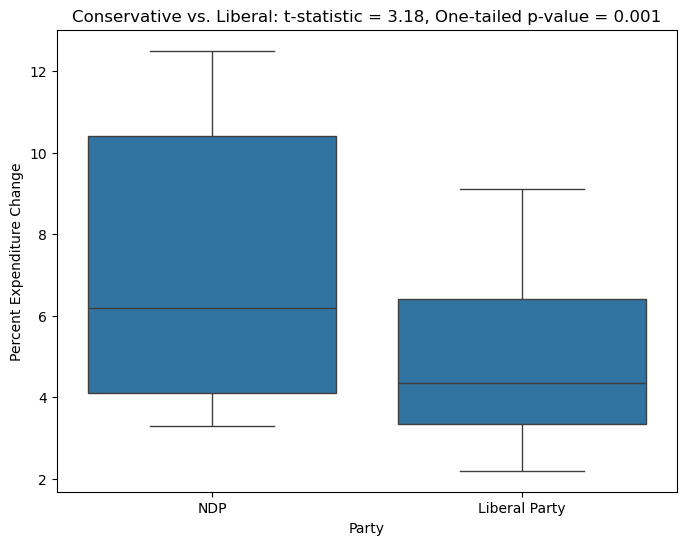

In [9]:
# Filter the dataframe to include only Conservative and Liberal parties
subset_df = expenditure_by_party_df[expenditure_by_party_df['party'].isin(['NDP', 'Liberal Party'])]

# Create a boxplot to compare the two parties
plt.figure(figsize=(8, 6))
sns.boxplot(x='party', y='percent_expenditure_change', data=subset_df)

# Annotate the plot with the t-test results
plt.title(f"Conservative vs. Liberal: t-statistic = {t_stat:.2f}, One-tailed p-value = {p_value_one_tailed:.3f}")
plt.xlabel("Party")
plt.ylabel("Percent Expenditure Change")

# Save the figure to a file
plt.savefig("../Figures/NDP_vs_liberal_ttest.png", dpi=300)
plt.show()

From this test we also reject the null hypothesis and confirm that NDP health expenditure change is greater than that of the Liberal party. 

### Summary of our Analysis

Throughout our analysis we arrived at the following meaningful results:

1. Using ANOVA we confirmed that at least one party has a mean health expenditure change that is significantly different from the others.

2. We confirmed through a pairwise hypothesis test that the conservative party has a mean health expenditure change greater than that of the Liberal party.

3. Similarily, 2e confirmed through a pairwise hypothesis test that the NDP party has a mean health expenditure change greater than that of the Liberal party.